# Identificação de Alzaimer em imagens RX

* Mohammad Reza Tabrizi

In [ ]:
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import expand_dims
#import torch
import os
from tqdm import tqdm #barra de progreso`
import cv2
from PIL import Image
from glob import glob
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,img_to_array
#para redimencionar
import sklearn
import skimage
from skimage.transform import resize
import random
from sklearn.metrics import confusion_matrix
import datetime
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.color import rgb2gray
from keras.utils import plot_model
from keras.models import Model,Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D, Flatten, Embedding, Dropout,BatchNormalization
from keras.layers import MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D,concatenate,Input
from keras.utils import to_categorical
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras import datasets, layers, models, optimizers
from keras.applications.imagenet_utils import preprocess_input
from sklearn.neighbors import KNeighborsClassifier
import pickle
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D,AveragePooling2D
from keras.layers.merge import concatenate

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/si

In [ ]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
x_train = drive.CreateFile({'id':"*****************"})   # https:/
x_train.GetContentFile('xtrain.npy')        # file name
x_test = drive.CreateFile({'id':"*****************"})   #https:/
x_test.GetContentFile('xtest.npy')  
x_All_original_image = drive.CreateFile({'id':"********************"})   # https:/
x_All_original_image.GetContentFile('X_all_Original_image.npy') 
y_train = drive.CreateFile({'id':"********************"})  #https://
y_train.GetContentFile('ytrain.npy')
y_test = drive.CreateFile({'id':"********************"})   #https:
y_test.GetContentFile('ytest.npy')        # 
y_All_original_omage = drive.CreateFile({'id':"********************"}) #https:
y_All_original_omage.GetContentFile('y_all_Original_image.npy')
X_Arurgmantation = drive.CreateFile({'id':"1Q9TsDMh__-********************"})   #https:
X_Arurgmantation.GetContentFile('X_Arurgmantation.npy')        # file name
y_Arurgmantation = drive.CreateFile({'id':"********************"})   #https
y_Arurgmantation.GetContentFile('y_Arurgmantation.npy') 

# Importar dados
### A seguinte função auxilia na importação dos dados recolhidos dos vários repositórios, associando a respetiva label aos mesmos. Os dados são convertidos em arrays:

In [ ]:
def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NonDemented']:
                label = 0
            elif folderName in ['ModerateDemented']:
                label = 1
            elif folderName in ['MildDemented']:
                label = 2
            elif folderName in ['VeryMildDemented']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                    img_file = cv2.imread(folder + folderName + '/' + image_filename)
                    if img_file is not None:
                        img_file = skimage.transform.resize(img_file, (200, 200, 3),mode='constant',
                                                            anti_aliasing=True)
                        img_file = rgb2gray(img_file)
                        img_arr = np.asarray(img_file)
                        X.append(img_arr)
                        y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

### Na primeira invocação (LOAD_FROM_IMAGES = True) é feito o load das imagens para os arrays, que são guardados. Nas invocações seguintes (LOAD_FROM_IMAGES = False) é apenas feito o load dos arrays guardados.

In [ ]:
train_dir = "Alz_DB/train/"
test_dir =  "Alz_DB/test/"
# cuando ya tenemos prosesamos imagenes es false
LOAD_FROM_IMAGES = True

In [ ]:
if LOAD_FROM_IMAGES:
    #cargamos las imágenes a los arrays
    X_train, y_train = get_data(train_dir)
    X_test, y_test= get_data(test_dir)
    
    #grabamos los arrays en archivos
    np.save('xtrain.npy', X_train)
    np.save('ytrain.npy', y_train)
    np.save('xtest.npy', X_test)
    np.save('ytest.npy', y_test)
    X_train = np.load('xtrain.npy')
    y_train = np.load('ytrain.npy')
    X_test = np.load('xtest.npy')
    y_test = np.load('ytest.npy')
else:
    #cargamos los arrays anteriormente grabados
    X_train = np.load('xtrain.npy')
    y_train = np.load('ytrain.npy')
    X_test = np.load('xtest.npy')
    y_test = np.load('ytest.npy')

100%|██████████| 448/448 [00:11<00:00, 37.54it/s]


### Por fim são anexadas às imagens de treino e test para contabilizar 

In [ ]:
y_all_Original_image= np.concatenate((y_train,y_test),axis=0)
X_all_Original_image=np.concatenate((X_train,X_test),axis=0)


### Guardamos as imagens em totalidade Como (X_all_Original_image e y_all_Original_image)

In [ ]:
np.save('y_all_Original_image.npy', y_all_Original_image)
np.save('X_all_Original_image.npy', X_all_Original_image)

In [ ]:
def count_labels(y_all_Original_image):
  how_many_0 = len(np.where(y_all_Original_image==0)[0])
  how_many_1 = len(np.where(y_all_Original_image==1)[0])
  how_many_2 = len(np.where(y_all_Original_image==2)[0])
  how_many_3 = len(np.where(y_all_Original_image==3)[0])

  print('#NonDemented:',how_many_0)
  print('#ModerateDemented:',how_many_1)
  print('#MildDemented:',how_many_2)
  print('#VeryMildDemented:',how_many_3)

### O plot evidencia um conjunto de dados Não  balanceado no caso de ModerateDemented (Label=1) e MildDemented (Label=2)

In [ ]:
df = pd.DataFrame()
df["labels"]=y_all_Original_image
lab = df['labels']
dist = lab.value_counts()

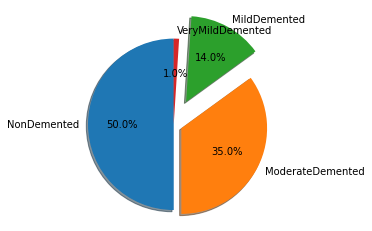

In [ ]:
labels ='NonDemented', 'ModerateDemented', 'MildDemented','VeryMildDemented'
sizes = lab.value_counts()
explode = (0, 0.1, 0.3, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [ ]:
print('X_all_Original_image:',X_all_Original_image.shape)
print('y_all_Original_image:',y_all_Original_image.shape)

X_all_Original_image: (6400, 200, 200)
y_all_Original_image: (6400,)


In [ ]:
count_labels(y_all_Original_image)

#NonDemented: 3200
#ModerateDemented: 64
#MildDemented: 896
#VeryMildDemented: 2240
